<a href="https://colab.research.google.com/github/oimartin/MNIST_Digit_Recognizer/blob/main/digits_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
from sklearn.model_selection import train_test_split

# Models
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Model Fit Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import roc_curve

## First View of Data

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/oimartin/MNIST_Digit_Recognizer/main/data/train.zip')
test = pd.read_csv('https://raw.githubusercontent.com/oimartin/MNIST_Digit_Recognizer/main/data/test.zip')

display(train.shape, test.shape)

(42000, 785)

(28000, 784)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# EDA

### Explore Label Column

In [5]:
train.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

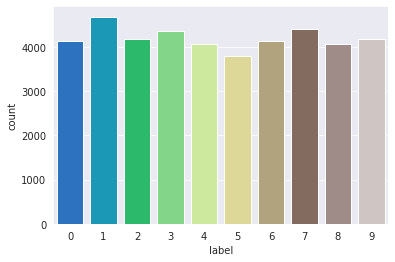

In [6]:
sns.set_style("darkgrid")
sns.countplot(data=train, x='label', palette='terrain')

### Missing Values

In [7]:
def null_sum (df):
  # double check for missing values
  nulls = df.isnull().sum()
  return nulls[nulls >=1]

In [8]:
null_sum(train)

Series([], dtype: int64)

In [10]:
null_sum(test)

Series([], dtype: int64)

## Split Data

In [38]:
def split_data (data_frame):

# Create subset of train data to run faster
  mini_df = data_frame.iloc[:1000, :]
  labels = mini_df.label.astype('category')
  mini_df = mini_df.drop(columns='label')

  X_train, X_test, labels_train, labels_test = train_test_split(mini_df,
                                                                labels,
                                                                test_size=0.2,
                                                                random_state=22)

  print(f'''X_train shape {X_train.shape}
labels_train shape {labels_train.shape}
X_test shape {X_test.shape}
labels_test {labels_test.shape}
''')
  return  X_train, X_test, labels_train, labels_test

In [40]:
X_train, X_test, labels_train, labels_test = split_data(train)

X_train shape (800, 784)
labels_train shape (800,)
X_test shape (200, 784)
labels_test (200,)



# Model

## Model Functions

In [32]:
def run_model (model, model_name, x_data, y_data, gridcv=False,params=None):
  if gridcv is True:
    clf = GridSearchCV(model,params)
    start = time()
    fitted_model = clf.fit(x_data, y_data)
    end = time()
    runtime = round((end - start),4)
    print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")

  elif gridcv is False:
    start = time()
    fitted_model = model.fit(x_data, y_data)
    end = time()
    runtime = round((end-start), 4)
    print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")
  return fitted_model, runtime

def submitted (fitted_model,model_name):
  pred = fitted_model.predict(test)
  df = pd.DataFrame(pred).rename(columns={0: 'Label'})
  df.index += 1
  df['ImageId'] = df.index
  df.to_csv(f"{model_name}_pred.csv", index=False) 
  return df

def prediction (fitted_model, x_feat):
  pred = fitted_model.predict(x_feat)
  return pred

def probability (fitted_model, x_feat):
  total_prob = fitted_model.predict_proba(x_feat)
  return total_prob

def evaluating_model (y_true, y_pred, model_name, train_test):
  df=pd.DataFrame({ 'model_name': [model_name, model_name, 
                                   model_name, model_name],
                   'type': [train_test, train_test,
                            train_test, train_test],
                   'metric_name': ["accuracy","f1",'recall',
                                   'precision'],
                   'metric' : [round(accuracy_score(y_true, y_pred),4),
                               round(f1_score(y_true, y_pred, average='micro'),4),
                               round(recall_score(y_true, y_pred, average='micro'), 4),
                               round(precision_score(y_true, y_pred, average='micro'), 4)]})
  display(df)
  return df

def prob_eval (y_true, y_prob, model_name, train_test):
  df=pd.DataFrame({ 'model_name': [model_name, model_name],
                   'type': [train_test, train_test],
                   'metric_name': ['log_loss','roc_auc'],
                   'metric' : [round(log_loss(y_true, y_prob), 4),
                               round(roc_auc_score(y_true, y_prob, multi_class='ovo'),4)]})
  display(df)
  return df


def eval_classification (y_pred, y_true, x_data, model_name, train_test):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
  print(f'''
  {model_name} for {train_test} Data
  FPR {fpr}
  TPR {tpr}
  ''')
  return


## Random Forest Classifier

In [14]:
RFC_model, RFC_rt = run_model(RandomForestClassifier(), 'RFC', 
                              mini_train, labels, False)

train_pred_RFC = prediction(RFC_model, X_train)
train_totprob_RFC = probability(RFC_model, X_train)

test_pred_RFC = prediction(RFC_model, X_test)
test_totprob_RFC = probability(RFC_model, X_test)

RFC took 0.5373 seconds or 0.009 minutes to run.


### RFC Evaluation

In [15]:
RFC_train = evaluating_model(labels_train, train_pred_RFC, 'RFC', 'Train')
RFC_train_prob = prob_eval(labels_train, train_totprob_RFC, 'RFC', 'Train')
eval_classification(train_pred_RFC, labels_train, X_train, 'RFC', 'Train')

print("---------------------")
RFC_test = evaluating_model(labels_test, test_pred_RFC, 'RFC', 'Test')
RFC_test_prob = prob_eval(labels_test, test_totprob_RFC, 'RFC', 'Test')
eval_classification(test_pred_RFC, labels_test, X_test, 'RFC', 'Test')

,model_name,type,metric_name,metric
0,RFC,Train,accuracy,1.0
1,RFC,Train,f1,1.0
2,RFC,Train,recall,1.0
3,RFC,Train,precision,1.0


,model_name,type,metric_name,metric
0,RFC,Train,log_loss,0.1828
1,RFC,Train,roc_auc,1.0000



  RFC for Train Data
  FPR [0.         0.11080332 0.20775623 0.32409972 0.43351801 0.53739612
 0.6468144  0.74792244 0.88642659 0.88642659 1.        ]
  TPR [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  
---------------------


,model_name,type,metric_name,metric
0,LG,Test,accuracy,1.0
1,LG,Test,f1,1.0
2,LG,Test,recall,1.0
3,LG,Test,precision,1.0


,model_name,type,metric_name,metric
0,LG,Test,log_loss,0.1844
1,LG,Test,roc_auc,1.0000



  LG for Test Data
  FPR [0.         0.09340659 0.21978022 0.33516484 0.43406593 0.51098901
 0.63736264 0.73076923 0.86263736 0.86263736 1.        ]
  TPR [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  


### Actual Test Data Predictions

In [30]:
submitted(RFC_model, 'RFC')

,Label,ImageId
1,2,1
2,0,2
3,9,3
4,2,4
5,2,5
...,...,...
27996,9,27996
27997,7,27997
27998,3,27998
27999,9,27999


## RFC with GridCV

### Run Model

In [17]:
parameters = {'n_estimators':[50,100,200,400],
              'criterion': ('gini', 'entropy'),
              'min_samples_split': [2,3,4],
              'random_state': [22]}

RFCcv_model, RFCcv_rt = run_model(RandomForestClassifier(),'RFCcv',
                                  X_train,
                                  labels_train, 
                                  True,
                                  parameters)

train_pred_RFCcv = prediction(RFCcv_model, X_train)
train_totprob_RFCcv = probability(RFCcv_model, X_train)

test_pred_RFCcv = prediction(RFCcv_model, X_test)
test_totprob_RFCcv = probability(RFCcv_model, X_test)

RFCcv took 127.9394 seconds or 2.1323 minutes to run.


### RFC with GridCV Evaluation

In [21]:
RFCcv_train = evaluating_model(labels_train, train_pred_RFCcv, 'RFCcv', 'Train')
RFCcv_train_prob = prob_eval(labels_train, train_totprob_RFCcv, 'RFCcv', 'Train')
eval_classification(train_pred_RFCcv, labels_train, X_train, 'RFCcv', 'Train')

print("---------------------")
RFC_test = evaluating_model(labels_test, test_pred_RFCcv, 'RFCcv', 'Test')
RFC_test_prob = prob_eval(labels_test, test_totprob_RFCcv, 'RFCcv', 'Test')
eval_classification(test_pred_RFCcv, labels_test, X_test, 'RFCcv', 'Test')

,model_name,type,metric_name,metric
0,RFCcv,Train,accuracy,1.0
1,RFCcv,Train,f1,1.0
2,RFCcv,Train,recall,1.0
3,RFCcv,Train,precision,1.0


,model_name,type,metric_name,metric
0,RFCcv,Train,log_loss,0.227
1,RFCcv,Train,roc_auc,1.000



  RFCcv for Train Data
  FPR [0.         0.11080332 0.20775623 0.32409972 0.43351801 0.53739612
 0.6468144  0.74792244 0.88642659 0.88642659 1.        ]
  TPR [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  
---------------------


,model_name,type,metric_name,metric
0,RFCcv,Test,accuracy,0.895
1,RFCcv,Test,f1,0.895
2,RFCcv,Test,recall,0.895
3,RFCcv,Test,precision,0.895


,model_name,type,metric_name,metric
0,RFCcv,Test,log_loss,0.7176
1,RFCcv,Test,roc_auc,0.9908



  RFCcv for Test Data
  FPR [0.         0.10989011 0.21428571 0.32417582 0.41758242 0.47802198
 0.6043956  0.71978022 0.85164835 0.86263736 1.        ]
  TPR [0.         0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 1.         1.        ]
  


### Actual Test Data Predictions

In [31]:
submitted(RFCcv_model, 'RFCcv')

,Label,ImageId
1,2,1
2,0,2
3,9,3
4,7,4
5,2,5
...,...,...
27996,9,27996
27997,7,27997
27998,3,27998
27999,9,27999


## Principal Component Analysis

In [33]:
data = pd.concat([train,test])
data.shape

(70000, 785)

In [41]:
X_train, X_test, labels_train, labels_test = split_data(data)

X_train shape (800, 784)
labels_train shape (800,)
X_test shape (200, 784)
labels_test (200,)



In [42]:
pca = PCA()
pca.fit(X_train, labels_train)
V = pca.components_

In [44]:
 x_pca_axis, y_pca_axis, z_pca_axis = 3 * V

ValueError: ignored